# Flood Detection

We are working on **flood detection** using satellite images from **Sentinel-1 (SAR)** and **Sentinel-2 (optical)** as our dataset. We are training a **Convolutional Neural Network (CNN)** to learn patterns of flooded and non-flooded areas from these images. Once the model is trained, we will use it to **predict floods in new SAR images of Guwahati**, helping us identify which areas are likely affected by flooding. This approach combines both radar and optical data to improve detection accuracy.

### Installing and Importing Required Libraries

In [ ]:
!pip install tensorflow
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install opencv-python
!pip install pillow
!pip install tqdm
!pip install scikit-learn
!pip install rasterio
!pip install ipython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 3.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 78.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77045 sha256=66af8b057bd84ceb3e6b520bfb5deaca007c88f894c556aad8f6553f8c2c3530
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.14.1
    Uninstalling wrapt-1.14.1:
      Successfully uninstalled wrapt-1.14.1
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.1

In [ ]:
import json
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import seaborn as sns
import os
import gc
import rasterio as rio
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import  cm
import cv2
from matplotlib import animation
from IPython.display import HTML
from tqdm import tqdm
from sklearn.model_selection import train_test_split

### Configuration Class

In [ ]:
class CFG:
    seed = 7
    img_size = (256, 256)  # resize images to this size
    BATCH_SIZE = 3
    Autotune = tf.data.AUTOTUNE
    validation_size = 0.2  # fraction of data for validation
    class_dict = {0: 'No Flooding', 1: 'Flooding'}
    test_run = False  # if True, run a small test

### Dataset Paths and Integrity Check

In [ ]:
# Paths for Sentinel-1 and Sentinel-2 data
s1_labels = '../input/sen12flood/sen12flood/sen12floods_s1_labels/sen12floods_s1_labels/'
s1_tiles = '../input/sen12flood/sen12flood/sen12floods_s1_source/sen12floods_s1_source/'

s2_tiles = '../input/sen12flood/sen12flood/sen12floods_s2_source/sen12floods_s2_source/'
s2_labels = '../input/sen12flood/sen12flood/sen12floods_s2_labels/sen12floods_s2_labels/'

# Check if all S1 label files have corresponding source files
s1_check = 0
for file in os.listdir(s1_labels):
    if os.path.exists(s1_tiles + '/' + file.replace('labels','source')):
        s1_check += 1

assert s1_check == len(os.listdir(s1_tiles)), 'Mismatch between S1 labels and source files!'

# Check if all S2 label files have corresponding source files
s2_check = 0
for file in os.listdir(s2_labels):
    if os.path.exists(s2_tiles + '/' + file.replace('labels','source')):
        s2_check += 1

assert s2_check == len(os.listdir(s2_tiles)), 'Mismatch between S2 labels and source files!'

s1_check, s2_check  # print counts to verify

(3332, 2237)

### JSON Loader Function

In [ ]:
def load_json(path):
    '''Load a JSON file from the given path'''
    with open(path, 'r') as file:
        js = json.load(file)  # read and parse JSON file

    return js  # return the parsed JSON data

### JSON Processing Functions

In [ ]:
# Process a single label json
def process_label_json(label_json):
    info_dict = {}

    info_dict['geometry'] = label_json['geometry']['coordinates']
    info_dict['label'] = label_json['properties']['FLOODING']
    info_dict['date'] = label_json['properties']['date']
    info_dict['tile_number'] = label_json['properties']['tile']

    return info_dict


def process_label_stac(stac_json):
    return stac_json['id']



def image_path_from_label_dir(image_parent_dir:str,
                              label_file :str)->str:

    return image_parent_dir + '/' + label_file.replace('labels','source')



def process_json(label_path,image_directory):


    # Get image directory for that label
    folder_id = label_path.rsplit('/',1)[1]
    image_dir_path = image_path_from_label_dir(image_directory,folder_id)

    if not os.path.exists(image_dir_path):
        return {'File_not_found':image_dir_path}


    for file in os.listdir(label_path):
        # If image dir exists
        if file.startswith('labels'):
            label_json = load_json(os.path.join(label_path,file))
        else:
            stac_json = load_json(os.path.join(label_path,file))


    # Get data
    info_dict = process_label_json(label_json)

    # Get id
    info_dict['id'] = process_label_stac(stac_json)

    # Location id
    info_dict['location_id'] = info_dict['id'].split('_')[3]


    info_dict['image_dir'] = image_dir_path


    return info_dict

### Creating and Processing Dataset DataFrame

In [ ]:
# Get dataframe from the nested label directory
def get_dataframe(label_directory,image_directory):
    records = []


    for folder in os.listdir(label_directory):
        if folder.startswith('sen12'):
        # Print folder and label_directory
            folder_path = label_directory + '/' + folder


            # Get data for a single example
            feature = process_json(label_path=folder_path,
                                   image_directory=image_directory)


            records.append(feature)


    return pd.DataFrame.from_records(data = records)


# Typecasting columns in dataset
def type_cast_dataset(dataset):
    dataset['label'] = dataset['label'].astype(int)

    dataset['date'] = pd.to_datetime(dataset['date'])
    dataset['tile_number'] = dataset['tile_number'].astype('int8')


    return dataset

### Creating and Inspecting Sentinel DataFrames

In [ ]:
%%time
# Prepare Sentinel-1 dataset
s1_data = type_cast_dataset(
    get_dataframe(
        label_directory=s1_labels,
        image_directory=s1_tiles
    )
)

# Prepare Sentinel-2 dataset
s2_data = type_cast_dataset(
    get_dataframe(
        label_directory=s2_labels,
        image_directory=s2_tiles
    )
)

# Print number of unique locations in each dataset
print(f'Number of unique locations in Sentinel1 (SAR) data: {s1_data.location_id.nunique()}')
print(f'Number of unique locations in Sentinel2 (optical) data: {s2_data.location_id.nunique()}')

# Show dataset shapes
s1_data.shape, s2_data.shape

Number of unique locations in Sentinel1 (SAR) data: 335
Number of unique locations in Sentinel2 (optical) data: 335
CPU times: user 1.18 s, sys: 1.59 s, total: 2.77 s
Wall time: 1min 14s


((3331, 7), (2236, 7))

### Saving DataFrames to CSV

In [ ]:
# Saving datasets
s1_data.to_csv('s1_data.csv',index=False)
s2_data.to_csv('s2_data.csv',index=False)

### Raster Loading Function

In [ ]:
def load_raster(filepath):
    '''Load a single-band raster file'''
    with rio.open(filepath) as file:
        raster = file.read().squeeze(axis=0)  # read first band and remove extra dimension

    return raster

### Loading and Preprocessing Sentinel TIFF Images

In [ ]:
def load_s1_tiffs(folder, scaling_values=[50., 100.]):
    images = []
    i = 0
    for im in sorted(os.listdir(folder)):
        if im.rsplit('.', maxsplit=1)[1] == 'tif':  # process only .tif files
            path = folder + '/' + im
            band = load_raster(path)
            band = band / scaling_values[i]  # scale band values
            band = cv2.resize(band, CFG.img_size)  # resize to target size
            images.append(band)
            i += 1
    return np.dstack(images)


def load_s2_tiffs(folder, scaling_value=10000.):
    images = []
    for im in sorted(os.listdir(folder)):
        if im.rsplit('.', maxsplit=1)[1] == 'tif':
            path = folder + '/' + im
            band = load_raster(path)
            band = band / scaling_value  # scale band values
            band = cv2.resize(band, CFG.img_size)
            images.append(band)
    return np.dstack(images)


# Load R, G, B bands
def load_rgb_tiffs(folder, scaling_value=10000.):
    images = []
    for im in sorted(os.listdir(folder)):
        name, file_format = im.rsplit('.', maxsplit=1)
        if file_format == 'tif' and name in ['B02', 'B03', 'B04']:
            path = folder + '/' + im
            band = load_raster(path)
            band = band / scaling_value
            band = cv2.resize(band, CFG.img_size)
            images.append(band)
    return np.dstack(images)[:, :, ::-1]  # convert to RGB order


# TensorFlow wrappers to use in tf.data pipelines
def tf_load_s1(path):
    path = path.numpy().decode('utf-8')
    return load_s1_tiffs(path)


def tf_load_s2(path):
    path = path.numpy().decode('utf-8')
    return load_s2_tiffs(path)


def tf_load_rgb(path):
    path = path.numpy().decode('utf-8')
    return load_rgb_tiffs(path)


# Preprocess S1 image for tf.data pipeline
def process_image_s1(filename):
    return tf.py_function(tf_load_s1, [filename], tf.float32)


# Preprocess S2 image for tf.data pipeline
def process_image_s2(filename):
    return tf.py_function(tf_load_s2, [filename], tf.float32)


# Preprocess RGB image for tf.data pipeline
def process_image_rgb(filename):
    return tf.py_function(tf_load_rgb, [filename], tf.float32)

### Counting and Filtering Sentinel-2 Rasters

In [ ]:
def count_rasters_in_folder(path):
    count = 0

    for file in os.listdir(path):
        if file.rsplit('.',1)[1] == 'tif':
            count +=1

    return count


s2_data['raster_count'] = s2_data.image_dir.apply(lambda x : count_rasters_in_folder(x))

# Value counts
s2_data['raster_count'].value_counts()


s2_data=s2_data[s2_data['raster_count']==12] # Take only valid rasters

### Isolating Single-Example Locations

In [ ]:
# Isolating single loaction ids because they will be a problem for stratification

single_index = s2_data['location_id'].value_counts()[s2_data['location_id'].value_counts()==1].index

single_index_df = s2_data[s2_data['location_id'].isin(single_index)].reset_index(drop=True)
s2_data0 = s2_data[~(s2_data['location_id'].isin(single_index))].reset_index(drop=True)

s2_data0.shape,single_index_df.shape

((2126, 8), (12, 8))

### Train-Validation Split

In [ ]:
# Train-validation split for Sentinel-1 data
s1_data_tr, s1_data_val = train_test_split(
    s1_data,
    test_size=CFG.validation_size,
    random_state=CFG.seed,
    stratify=s1_data.location_id
)

# Train-validation split for Sentinel-2 data
s2_data_tr, s2_data_val = train_test_split(
    s2_data0,
    test_size=CFG.validation_size,
    random_state=CFG.seed,
    stratify=s2_data0.location_id
)

# Add single_index_df to the training set
s2_data_tr = s2_data_tr.append(single_index_df, ignore_index=True)

# Clean up memory
del s2_data0;gc.collect()

0

### Inspect Label Distribution

In [ ]:
s1_data_tr.label.value_counts(1),s1_data_val.label.value_counts(1)

(0    0.69482
 1    0.30518
 Name: label, dtype: float64,
 0    0.673163
 1    0.326837
 Name: label, dtype: float64)

In [ ]:
s2_data_tr.label.value_counts(1),s2_data_val.label.value_counts(1)

(0    0.773364
 1    0.226636
 Name: label, dtype: float64,
 0    0.725352
 1    0.274648
 Name: label, dtype: float64)

### Image Augmentation Functions

In [ ]:
 # Simple augmentation for multispectral images
def augment_image_multispectral(image):
    image = tf.image.random_flip_left_right(image)  # horizontal flip
    image = tf.image.random_flip_up_down(image)     # vertical flip
    image = tf.image.random_crop(image, size=(*CFG.img_size, 12))

    rot = tf.random.normal((1,), mean=0.35, stddev=0.15)
    if rot > 0.5:
        image = tf.image.rot90(image)

    return image

# Simple augmentation for RGB images
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_crop(image, size=(*CFG.img_size, 3))

    rot = tf.random.normal((1,), mean=0.35, stddev=0.15)
    if rot > 0.5:
        image = tf.image.rot90(image)

    return image

### TensorFlow Dataset Creation and Pipeline Optimization

In [ ]:
def get_tf_dataset(image_paths,
                   labels=None,
                   image_processing_fn=None, # Function to preprocess or decode images
                   augment_fn=None
                  ):


    # Create the dataset of image file paths
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)

    # Load and preprocess images using the provided function
    image_dataset = image_dataset.map(image_processing_fn,
                                      num_parallel_calls=tf.data.AUTOTUNE)

    # Apply data augmentation if a function is provided
    if augment_fn is not None:
        image_dataset = image_dataset.map(augment_fn,
                                          num_parallel_calls=tf.data.AUTOTUNE)

    # If labels are provided, create a label dataset and combine it with the images
    if labels is not None:
        labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
        return tf.data.Dataset.zip((image_dataset, labels_dataset))

    return image_dataset



def optimize_pipeline(tf_dataset,
                      batch_size=CFG.BATCH_SIZE,
                      Autotune_fn=CFG.Autotune,
                      cache=False,
                      batch=True):


    tf_dataset = tf_dataset.prefetch(buffer_size=Autotune_fn)

    # Optionally cache the dataset in memory for faster access
    if cache:
        tf_dataset = tf_dataset.cache()

    # Shuffle the dataset to ensure randomness during training
    tf_dataset = tf_dataset.shuffle(buffer_size=50)

    # Optionally divide the dataset into batches
    if batch:
        tf_dataset = tf_dataset.batch(batch_size)

    return tf_dataset

### Creating TensorFlow Datasets

In [ ]:
# For Sentinel 1 dataset without using augmentation

S1_dataset_tr = optimize_pipeline(tf_dataset=get_tf_dataset(image_paths = s1_data_tr.image_dir.values,
                                               labels = s1_data_tr.label,
                                               image_processing_fn = process_image_s1),

                                  batch_size = 3 * CFG.BATCH_SIZE)


S1_dataset_val = optimize_pipeline(tf_dataset = get_tf_dataset(image_paths = s1_data_val.image_dir.values,
                                                           labels = s1_data_val.label,
                                                           image_processing_fn = process_image_s1 ),
                                   batch_size = 3* CFG.BATCH_SIZE
                                  )

In [ ]:
# For Sentinel 2 dataset
S2_dataset_tr = optimize_pipeline(get_tf_dataset(image_paths = s2_data_tr.image_dir.values,
                                                   labels = s2_data_tr.label,
                                                   image_processing_fn = process_image_s2,
                                                   augment_fn = augment_image_multispectral)
                                 )


S2_dataset_val = optimize_pipeline(get_tf_dataset(image_paths = s2_data_val.image_dir.values,
                                                   labels = s2_data_val.label,
                                                   image_processing_fn = process_image_s2,
                                                   augment_fn = augment_image_multispectral)
                                  )

### Inspecting a Batch from Dataset

In [ ]:
for x,y in S1_dataset_tr.take(1): # Taking only one batch for checking
    print(f'shape of SAR dataset input {x.shape}')

shape of SAR dataset input (9, 256, 256, 2)


In [ ]:
for x,y in S2_dataset_tr.take(1): # Taking only one batch for checking
    print(f'shape of MultiSpectral dataset input {x.shape}')

shape of MultiSpectral dataset input (3, 256, 256, 12)


### Multi-Channel CNN Model Definition

In [ ]:
def multichannel_cnn(num_channels: int,
                     hidden_units: int,  # Number of units in the hidden dense layer
                     weights=None        # 'imagenet' to use pretrained weights, None for random init
                     ):


    # Load the ResNet50V2 backbone without the top classification layer
    backbone = tf.keras.applications.resnet_v2.ResNet50V2(
        include_top=False,
        input_shape=(*CFG.img_size, num_channels),
        weights=weights,
        pooling='avg'
    )

    # Add normalization and a dense layer for feature refinement
    x = tf.keras.layers.BatchNormalization()(backbone.output)
    x = tf.keras.layers.Dense(hidden_units, activation='relu')(x)

    # Regularization layers to stabilize training and reduce overfitting
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)

    # Final classification layer
    final_out = tf.keras.layers.Dense(2, activation='softmax')(x)

    # Define the complete model
    model = tf.keras.Model(inputs=backbone.input, outputs=final_out)

    return model



def plot_history(history, addn_metric=None):
    his = pd.DataFrame(history.history)

    if addn_metric:
        plt.subplots(1, 3, figsize=(20, 6))

        # Plot training vs validation loss
        ax1 = plt.subplot(1, 3, 1)
        ax1.plot(range(len(his)), his['loss'], color='g', label='Training')
        ax1.plot(range(len(his)), his['val_loss'], color='r', label='Validation')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.set_title('Loss per Epoch')

        # Plot training vs validation accuracy
        ax2 = plt.subplot(1, 3, 2)
        ax2.plot(range(len(his)), his['accuracy'], color='g', label='Training')
        ax2.plot(range(len(his)), his['val_accuracy'], color='r', label='Validation')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.set_title('Accuracy per Epoch')

        # Plot additional metric if provided
        ax3 = plt.subplot(1, 3, 3)
        ax3.plot(range(len(his)), his[f'{addn_metric}'], color='g', label='Training')
        ax3.plot(range(len(his)), his[f'val_{addn_metric}'], color='r', label='Validation')
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel(f'{addn_metric}')
        ax3.legend()
        ax3.set_title(f'{addn_metric} per Epoch')

    else:
        plt.subplots(1, 2, figsize=(20, 8))

        # Plot training vs validation loss
        ax1 = plt.subplot(1, 2, 1)
        ax1.plot(range(len(his)), his['loss'], color='g', label='Training')
        ax1.plot(range(len(his)), his['val_loss'], color='r', label='Validation')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.set_title('Loss per Epoch')

        # Plot training vs validation accuracy
        ax2 = plt.subplot(1, 2, 2)
        ax2.plot(range(len(his)), his['accuracy'], color='g', label='Training')
        ax2.plot(range(len(his)), his['val_accuracy'], color='r', label='Validation')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.set_title('Accuracy per Epoch')

    plt.show()

### Metrics

In [ ]:
# Calculate recall metric
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


# Calculate precision metric
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


# Calculate F1 score
def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

### Building and training the SAR CNN

In [ ]:
SAR_CNN = multichannel_cnn(num_channels = 2,
                           hidden_units = 512, # Number of  hidden dense
                          )



SAR_CNN.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy',f1_score,recall_m,precision_m]
               )

!mkdir CNN_models

/opt/conda/lib/python3.7/site-packages/keras/applications/imagenet_utils.py:333: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  str(input_shape[-1]) + ' input channels.')


### Defining callbacks

In [ ]:
EPOCHS = 2 if CFG.test_run else 50

# Reduce learning rate
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(patience=3,
                                                factor=0.75,
                                                min_delta=1e-2,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                mode='max')

# Early stopping
early_stopping=tf.keras.callbacks.EarlyStopping(patience=15,
                                              min_delta=1e-3,
                                              monitor='val_accuracy',
                                              restore_best_weights=True,
                                              mode='max')


# Exponential decay
def lr_scheduler(epoch, lr):

# Learning rate scheduler, decays expo after the tenth epoch

    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)



learning_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)


callbacks_1= [reduce_lr,early_stopping,learning_scheduler]

### Training on SAR data

Epoch 1/50
296/296 [==============================] - 71s 197ms/step - loss: 0.6626 - accuracy: 0.6622 - f1_score: 0.4452 - recall_m: 0.9595 - precision_m: 0.3052 - val_loss: 0.8843 - val_accuracy: 0.3268 - val_f1_score: 0.4632 - val_recall_m: 0.9067 - val_precision_m: 0.3230
Epoch 2/50
296/296 [==============================] - 41s 137ms/step - loss: 0.5955 - accuracy: 0.7196 - f1_score: 0.4442 - recall_m: 0.9595 - precision_m: 0.3052 - val_loss: 0.6455 - val_accuracy: 0.6762 - val_f1_score: 0.4705 - val_recall_m: 0.9867 - val_precision_m: 0.3230
Epoch 3/50
296/296 [==============================] - 41s 137ms/step - loss: 0.5606 - accuracy: 0.7399 - f1_score: 0.4476 - recall_m: 0.9764 - precision_m: 0.3052 - val_loss: 0.6529 - val_accuracy: 0.6732 - val_f1_score: 0.4656 - val_recall_m: 0.9600 - val_precision_m: 0.3230
Epoch 4/50
296/296 [==============================] - 42s 139ms/step - loss: 0.5444 - accuracy: 0.7459 - f1_score: 0.4458 - recall_m: 0.9493 - precision_m: 0.3052 - val_

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


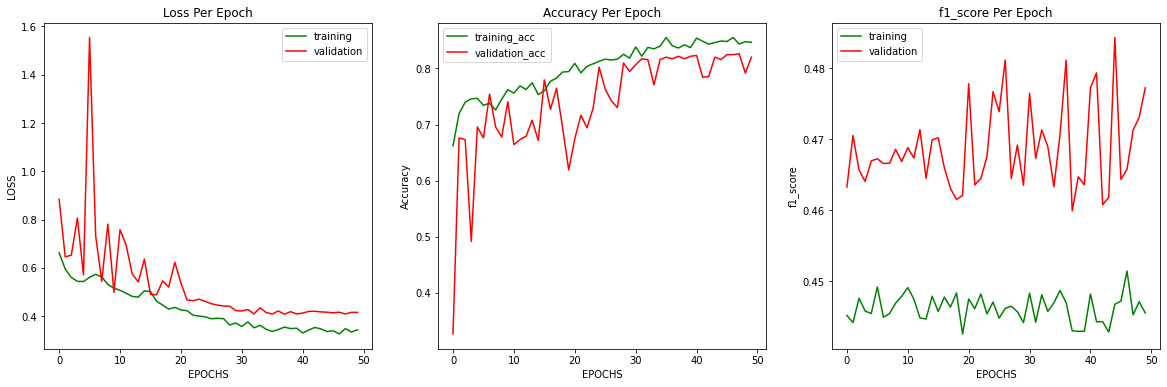

In [ ]:
hist1 = SAR_CNN.fit(S1_dataset_tr,
                    validation_data = S1_dataset_val,
                    epochs = EPOCHS,
                    callbacks = callbacks_1
                   )


# Save model
sar_model_path = 'CNN_models/SAR_CNN.h5'
SAR_CNN.save(filepath = 'CNN_models/SAR_CNN.h5')


# Plot history
plot_history(hist1,'f1_score')

### Evaluate on validation dataset

In [ ]:
SAR_CNN.evaluate(S1_dataset_val)

del SAR_CNN;gc.collect()

K.clear_session()

75/75 [==============================] - 6s 75ms/step - loss: 0.4156 - accuracy: 0.8201 - f1_score: 0.4655 - recall_m: 0.9600 - precision_m: 0.3230


### Loading a Saved SAR CNN Model

In [ ]:
SAR_CNN = tf.keras.models.load_model('CNN_models/SAR_CNN.h5',
                                     custom_objects={'f1_score':f1_score,
                                                     'recall_m':recall_m,
                                                     'precision_m':precision_m}
                                    )

### Path to Test Image

In [ ]:
img_path = "/kaggle/input/test-data/subset_2_of_subset_0_of_S1A_IW_GRDH_1SDV_20220628T115711_20220628T115736_043863_053C7E_C351_Orb_Cal_Spk_TC.tif"

### Prediction and testing

In [ ]:
# Define the mapping between model output classes and their labels
label_map = {0: "No Flooding", 1: "Flooding"}

# Configuration class — must match the settings used during training
class CFG:
    img_size = (256, 256)


print("Loading the trained model...")
SAR_CNN = tf.keras.models.load_model(
    'CNN_models/SAR_CNN.h5',
    custom_objects={'f1_score': None, 'recall_m': None, 'precision_m': None}
)
print("Model loaded successfully!")


def preprocess_sar_image(geotiff_path):

    # Open the GeoTIFF file and read all its bands
    with rasterio.open(geotiff_path) as dataset:
        # Ensure the file has both VV and VH bands
        if dataset.count < 2:
            raise ValueError("The input GeoTIFF must have at least 2 bands (VV and VH).")

        # Read all bands into a NumPy array
        all_bands = dataset.read()

    # Reorder dimensions to match the model’s expected input format
    img = all_bands.transpose((1, 2, 0))

    # Apply the same preprocessing steps used during training
    img = img.astype(np.float32) / 50.0
    img = cv2.resize(img, CFG.img_size, interpolation=cv2.INTER_AREA)

    # Add an extra dimension to represent a single image batch
    img = np.expand_dims(img, axis=0)

    return img


def predict_flood(geotiff_path):

    # Prepare the image for model input
    model_input = preprocess_sar_image(geotiff_path)

    # Run the prediction
    pred_probs = SAR_CNN.predict(model_input)

    # Extract the most likely class and its confidence
    class_idx = np.argmax(pred_probs, axis=1)[0]
    confidence = pred_probs[0][class_idx]

    return label_map[class_idx], confidence


# Provide the path to a single SAR GeoTIFF image
geotiff_image_path = "/kaggle/input/test-data/subset_2_of_subset_0_of_S1A_IW_GRDH_1SDV_20220628T115711_20220628T115736_043863_053C7E_C351_Orb_Cal_Spk_TC.tif"

# Run the prediction and display results
try:
    predicted_label, confidence_score = predict_flood(geotiff_image_path)

    print("\n--- Prediction Result ---")
    print(f"Label: {predicted_label}")
    print(f"Confidence: {confidence_score:.4f}")

except Exception as e:
    print(f"\nAn error occurred during prediction: {e}")

Loading trained model...
Model loaded successfully.

--- Prediction Result ---
Label: Flooding
Confidence: 0.7943


In [ ]:
print(f"Predicted Label: {predicted_label}")
print(f"Confidence Score: {confidence_score:.4f}")

Predicted Label: Flooding
Confidence Score: 0.7943
